## Shortlist d'articles

Le but de ce notebook est de déterminer une liste restreinte d'articles, statique ou dynamique, qui sera utilisée pour les modélisations.

On se basera pour cela sur les ventes, couplées aux critères suivants : 
- Groupe de client
- Groupe de code postal
- Âge du client
- Catégories préférées par le client
- Articles susceptibles d'être rachetés
- Articles qui vont de pair avec des articles déjà achetés

**L'idée est de déterminer une liste de 50 articles par client, sur la base de laquelle le score maximal obtenu sera satisfaisant.**

In [20]:
import pandas as pd
import numpy as np

ages_centers = [15, 25, 35, 45, 55, 65]

def get_maximum_score(purchased_articles, shortlist):
    """Get the maximum (linear) score that can be obtained with an article shortlist.

    Args:
        purchased_articles (pd.Series): Series containing the list of purchased article for each customer.
        shortlist (pd.Series): Series containing the shortlist of articles for each customer.
        
        
    Returns:
        A pd.Series object containing the maximum linear score for each customer.
    """
    return pd.concat([purchased_articles.rename('purchased_articles'), shortlist.rename('shortlist')], axis = 1).apply(
        lambda x: min( 
            np.sum(
                np.where(
                    [article in x.purchased_articles for article in x.shortlist], # Gives one sub-point for right article.
                    1, 
                    0
                )
            ) / min(len(x.purchased_articles), 12), # Predict 12 articles is sufficient for having the maximum score.
            1 # The max score is 1 per article.
        ),
    axis=1)

def map12_score_table():
    """Get a score array for MAP@12.

    Returns:
        An array that gives the maximum score contribution for each position in the list.
    """
        
    # Get a table containing the subscore for each position, depending on the purchased article length.
    score_table = np.zeros(12)
    
    for position in range(0, 12):
        for i in range(position, 12): # iterate on each time the article intervenes on the score.
            score_table[position] += 1 / (i + 1)

    score_table = score_table / np.sum(score_table)
    
    return score_table

def map12(purchased_articles, prediction):
    """Process the map12 score from the purchased articles and a prediction.

    Args:
        purchased_articles (pd.Series): the list of purchased articles for each customer
        prediction (pd.Series): the prediction (list format) for each customer.
        
    Returns:
        A pd.Series object containing the score for each customer.
    """
    
    return pd.concat([purchased_articles.rename('purchased_articles'), prediction.rename('prediction')], axis = 1).apply(
        lambda x: np.sum(
            np.fromiter(
                (np.where(
                x.prediction[cutoff] in x.purchased_articles,
                np.sum(
                    np.fromiter(
                        (np.where(
                            x.prediction[position] in x.purchased_articles,
                            1 / (cutoff + 1), 
                            0
                        ) for position in range(0, cutoff + 1)),
                        float
                    )
                ),
                0
            ) for cutoff in range(0, min(len(x.prediction), 12)) ),
            float)
        ) / min(len(x.purchased_articles), 12),
    axis=1)

### Création des données de validations
-> Sur la base de la dernière semaine du jeu de données

In [2]:
transactions = pd.read_pickle('pickles/transactions.pkl')
transactions_last_week = transactions[transactions['week_number'] == 0]

In [3]:
validation_purchases = transactions_last_week.groupby(['customer_id'], as_index = False).agg(
    purchase_list = ('article_id', lambda x: list(x))
)

In [95]:
transactions.groupby('week_number')['customer_id'].nunique().describe()

count       105.000000
mean      76917.314286
std       15344.606781
min       49127.000000
25%       68004.000000
50%       73096.000000
75%       80937.000000
max      134010.000000
Name: customer_id, dtype: float64

### Création des listes pour chaque Client
Ici, on travaille uniquement sur les clients qui ont des achats.

In [8]:
customers = pd.read_pickle('pickles/customers_second_iteration.pkl')
articles = pd.read_pickle('pickles/articles_second_iteration.pkl')

In [9]:
before_last_week_sales = transactions[transactions['week_number'] == 1]

In [10]:

validation_customers = validation_purchases[['customer_id']].merge(customers, on = 'customer_id', how = 'left')
validation_customers.drop(['FN', 'Active', 'club_member_status',
       'fashion_news_frequency', 'age', 'postal_code', 'average_cart_articles',
       'average_cart_price', 'total_carts', 'total_articles', 'total_price',
       'average_cart_interval', 'repurchases', 'repurchases_interval'], 1, inplace = True)
before_last_week_sales = transactions[transactions['week_number'] == 1].merge(customers, on = 'customer_id', how = 'left')

/tmp/ipykernel_5197/214588795.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  validation_customers.drop(['FN', 'Active', 'club_member_status',


In [11]:
top_sales_validation = before_last_week_sales.groupby(['article_id', 'postal_code_group', 'group'], as_index = False).agg(
    sales = ('article_id', 'count'),
    age_around_15 = ('age_around_15', 'sum'),
    age_around_25 = ('age_around_25', 'sum'),
    age_around_35 = ('age_around_35', 'sum'),
    age_around_45 = ('age_around_45', 'sum'),
    age_around_55 = ('age_around_55', 'sum'),
    age_around_65 = ('age_around_65', 'sum'),
)

    
# Add index group
top_sales_validation = top_sales_validation.merge(articles[['article_id', 'index_group_name']], on = 'article_id')
top_sales_validation

,article_id,postal_code_group,group,sales,age_around_15,age_around_25,age_around_35,age_around_45,age_around_55,age_around_65,index_group_name
0,0108775044,4,4,1,0.0,0.0,0.0,0.2,0.8,0.0,Ladieswear
1,0108775044,5,0,1,0.0,0.3,0.7,0.0,0.0,0.0,Ladieswear
2,0111565001,1,0,1,0.0,0.5,0.5,0.0,0.0,0.0,Ladieswear
3,0111565001,1,2,1,0.1,0.9,0.0,0.0,0.0,0.0,Ladieswear
4,0111565001,1,4,1,0.0,0.0,0.0,0.5,0.5,0.0,Ladieswear
...,...,...,...,...,...,...,...,...,...,...,...
106042,0956217002,4,0,1,0.0,0.4,0.6,0.0,0.0,0.0,Ladieswear
106043,0956217002,4,1,2,0.0,0.0,0.0,0.0,0.7,1.2,Ladieswear
106044,0956217002,4,2,1,0.0,0.9,0.1,0.0,0.0,0.0,Ladieswear
106045,0956217002,4,3,3,0.2,2.5,0.3,0.0,0.0,0.0,Ladieswear


#### Articles les plus vendus

In [12]:
top_sales_general = top_sales_validation.groupby('article_id', as_index = False)['sales'].sum().nlargest(n = 100, columns="sales")['article_id'].tolist()
validation_customers['best_articles'] = validation_customers['customer_id'].apply(lambda x: top_sales_general)
validation_customers.head(5)

,customer_id,baby,divided,ladieswear,menswear,sport,age_around_15,age_around_25,age_around_35,age_around_45,age_around_55,age_around_65,postal_code_group,group,best_articles
0,00039306476aaf41a07fed942884f16b30abfa83a2a8be...,0.000000,0.161290,0.645161,0.193548,0.000000,0.0,0.8,0.2,0.0,0.0,0.0,1,2,"[0909370001, 0865799006, 0918522001, 092424300..."
1,0003e867a930d0d6842f923d6ba7c9b77aba33fe2a0fbf...,0.000000,0.944444,0.055556,0.000000,0.000000,0.0,0.2,0.8,0.0,0.0,0.0,4,3,"[0909370001, 0865799006, 0918522001, 092424300..."
2,000493dd9fc463df1acc2081450c9e75ef8e87d5dd17ed...,0.000000,0.875000,0.125000,0.000000,0.000000,0.0,0.6,0.4,0.0,0.0,0.0,1,2,"[0909370001, 0865799006, 0918522001, 092424300..."
3,000525e3fe01600d717da8423643a8303390a055c578ed...,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,5,3,"[0909370001, 0865799006, 0918522001, 092424300..."
4,00077dbd5c4a4991e092e63893ccf29294a9d5c46e8501...,0.055556,0.208333,0.694444,0.013889,0.027778,0.2,0.8,0.0,0.0,0.0,0.0,0,2,"[0909370001, 0865799006, 0918522001, 092424300..."


In [21]:
best_articles_map12 = map12(
    validation_purchases['purchase_list'],
    validation_customers['best_articles'].apply(lambda x: x[0:11])
)

best_articles_map12.sum() / len(best_articles_map12)

0.008336265044440449

#### Classement par groupe de code postal

In [9]:
postal_code_groups = top_sales_validation['postal_code_group'].unique()

postal_codes_lists = {}

top_sales_postal_code_groups = top_sales_validation.groupby(['article_id', 'postal_code_group'], as_index = False)['sales'].sum()

for group in postal_code_groups :
    postal_codes_lists[group] = top_sales_postal_code_groups[top_sales_postal_code_groups['postal_code_group'] == group].nlargest(n = 100, columns="sales")['article_id'].tolist()

validation_customers['postal_group_articles'] = validation_customers['postal_code_group'].apply(lambda x: postal_codes_lists[x])

#### Classement par groupe d'utilisateur

In [10]:
customer_groups = top_sales_validation['group'].unique()

customer_group_lists = {}

top_sales_customer_groups = top_sales_validation.groupby(['article_id', 'group'], as_index = False)['sales'].sum()

for group in customer_groups :
    customer_group_lists[group] = top_sales_customer_groups[top_sales_customer_groups['group'] == group].nlargest(n = 100, columns="sales")['article_id'].tolist()

validation_customers['customer_group_articles'] = validation_customers['group'].apply(lambda x: customer_group_lists[x])

#### Classement par catégorie

In [11]:
categories = top_sales_validation['index_group_name'].unique()
categories_string = []

top_sales_categories = top_sales_validation.groupby(['article_id', 'index_group_name'], as_index = False)['sales'].sum()

top_sales_category_lists = {}

for category in categories:
    category_string = category.split('/')[0].lower()
    categories_string.append(category_string)
    
    top_sales_category_lists[category_string] = top_sales_categories[top_sales_categories['index_group_name'] == category].nlargest(n = 100, columns = ['sales'])
    top_sales_category_lists[category_string]['shares'] = top_sales_category_lists[category_string]['sales'] / top_sales_category_lists[category_string]['sales'].sum()
    top_sales_category_lists[category_string]['index_group_name'] = category_string


In [13]:
def get_category_list(x, balanced = False):
    global categories
    global top_sales_category_lists
    
    top_sales_weighted = []
    
    for category in categories_string:
    
        if x[category] == 0:
            continue
        
        field = 'shares' if balanced else 'sales'
        
        top_sales_category_lists[category]['sales_weighted'] = top_sales_category_lists[category][field] * x[category] * balanced
        
        top_sales_weighted.append(top_sales_category_lists[category])
        
    return pd.concat(top_sales_weighted).nlargest(n = 100, columns = ['sales_weighted'])['article_id'].tolist()

def get_category_list_weighted(x):
    return get_category_list(x, balanced = True)

In [14]:
validation_customers['category_list'] = validation_customers.apply(get_category_list, axis = 1)


In [ ]:
# liste utilisant les parts de vente dans chaque catégorie et non les ventes en valeur absolue.
validation_customers['category_list_balanced'] = validation_customers.apply(get_category_list_weighted, axis = 1)

#### Classement par âge (pondération discrète)

In [15]:
customer_age_lists = {}

top_sales_ages = top_sales_validation.groupby('article_id', as_index = False).agg(
    sales = ('sales', 'sum'),
    age_around_15 = ('age_around_15', 'sum'),
    age_around_25 = ('age_around_25', 'sum'),
    age_around_35 = ('age_around_35', 'sum'),
    age_around_45 = ('age_around_45', 'sum'),
    age_around_55 = ('age_around_55', 'sum'),
    age_around_65 = ('age_around_65', 'sum'),
)

validation_customers['age_articles'] = ''

for age in ages_centers :
    age_list = top_sales_ages.nlargest(n = 100, columns=f"age_around_{age}")['article_id'].tolist()
    
    validation_customers['age_articles'] = validation_customers.apply(
        lambda x: 
            age_list if x[f"age_around_{age}"] > 0.5 
            else x['age_articles']
        , axis = 1
    )

#### Classement par âge (pondération continue)

In [ ]:
def get_age_list(x, balanced = False):
    global categories
    global top_sales_category_lists
    
    top_sales_weighted = []
    
    for age in ages_centers:
        column = f'age_around_{age}'] == 0:
            continue
        
        field = 'shares' if balanced else 'sales'
        
        top_sales_category_lists[category]['sales_weighted'] = top_sales_category_lists[category][field] * x[category] * balanced
        
        top_sales_weighted.append(top_sales_category_lists[category])
        
    return pd.concat(top_sales_weighted).nlargest(n = 100, columns = ['sales_weighted'])['article_id'].tolist()


validation_customers['age_list'] = validation_customers.apply(get_category_list, axis = 1)

In [36]:
def max_score_curve(purchased_articles, shortlist, max = 100):
    curve = [0]
    
    length = len(shortlist)
    
    for i in np.arange(5, 101, 5):
        print(f"\r Calcul pour les articles 1-{i}", end="")
        score = get_maximum_score(
                purchased_articles,
                shortlist.apply(lambda x: x[0:i])
            ).sum() / length
            
        curve.append(
            score
        )
    
    return curve

In [25]:
validation_purchases.to_pickle('pickles/second_iteration_validation_purchases.pkl')
validation_customers.to_pickle('pickles/second_iteration_shortlists.pkl')

In [37]:
best_articles_curve = max_score_curve(validation_purchases['purchase_list'], validation_customers['best_articles'])

 Calcul pour les articles 1-100

In [38]:
postal_group_curve = max_score_curve(validation_purchases['purchase_list'], validation_customers['postal_group_articles'])

 Calcul pour les articles 1-100

In [39]:
customer_group_curve = max_score_curve(validation_purchases['purchase_list'], validation_customers['customer_group_articles'])

 Calcul pour les articles 1-100

In [40]:
category_list_curve = max_score_curve(validation_purchases['purchase_list'], validation_customers['category_list'])

 Calcul pour les articles 1-100

In [41]:
age_curve = max_score_curve(validation_purchases['purchase_list'], validation_customers['age_articles'])

 Calcul pour les articles 1-100

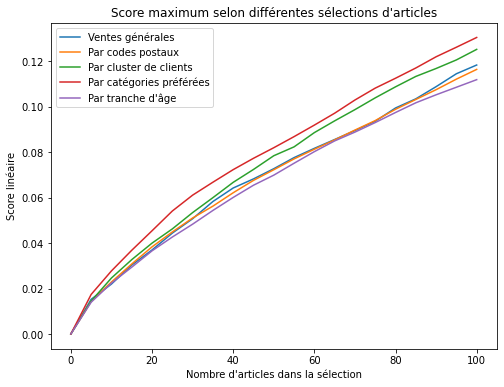

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

x = np.arange(0, 101, 5)

plt.figure(figsize = (8, 6))
plt.plot(x, best_articles_curve, label = "Ventes générales")
plt.plot(x, postal_group_curve, label = "Par codes postaux")
plt.plot(x, customer_group_curve, label = "Par cluster de clients")
plt.plot(x, category_list_curve, label = "Par catégories préférées")
plt.plot(x, age_curve, label = "Par tranche d'âge")

plt.xlabel("Nombre d'articles dans la sélection")
plt.ylabel("Score linéaire")
plt.title("Score maximum selon différentes sélections d'articles")
plt.legend()

plt.show()